# Generalization experiment (Section 3.4)

Train only on Court of Appeals tasks, plot accuracy on both Court of Appeals and Supreme Court tasks.

In [1]:
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
palette = sns.color_palette("colorblind")
import matplotlib.pyplot as plt

from utils import responses_to_counts, load_responses, compute_case_acc

In [2]:
# Load the responses of every model checkpoint
base_dir = 'results/generalization-experiment/'
subdirs = os.listdir(base_dir)
responses = load_responses({}, subdirs, base_dir)

llama_3_models = ['llama-3-8b-instruct', 'llama-3-70b-instruct', 'lawma-8b']
responses = load_responses(responses, llama_3_models, 'results/model_responses/')

100%|██████████| 260/260 [00:00<00:00, 296.21it/s]


progress-30 has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 268.11it/s]


progress-100 has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 300.80it/s]


progress-2000 has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 253.54it/s]


progress-600 has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 285.41it/s]


progress-3000 has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 184.65it/s]


progress-300 has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 300.84it/s]


progress-60 has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 182.03it/s]


progress-1000 has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 322.64it/s]


progress-10 has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 180.44it/s]


llama-3-8b-instruct has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 324.61it/s]


llama-3-70b-instruct has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 240.31it/s]

lawma-8b has 260 tasks


In [3]:
trials = {}
for model, model_responses in responses.items():
    trials[model] = {}
    for file, response in tqdm(model_responses.items()):
        trials[model][file] = responses_to_counts(response, gpt4=model=='gpt4')

100%|██████████| 260/260 [00:00<00:00, 7153.43it/s]


In [4]:
processed_results = {}
for run, values in trials.items():
    if not run.startswith('progress'):
        continue

    steps = int(run.split('-')[-1])
    processed_results[steps] = {
        'sc': compute_case_acc(values, 'sc_'),
        'songer': compute_case_acc(values, 'songer_'),
    }

In [5]:
y_base = {
    '8b': compute_case_acc(trials['llama-3-8b-instruct'], 'sc_')[0],
    '70b': compute_case_acc(trials['llama-3-70b-instruct'], 'sc_')[0],
    'lawma-8b': compute_case_acc(trials['lawma-8b'], 'sc_')[0],
}

def error_bar_transform(bars):
    min_ = [bar[0] for bar in bars]
    max_ = [bar[1] for bar in bars]
    return np.c_[min_, max_].T

x = sorted(list(processed_results.keys()))
y_sc = [processed_results[steps]['sc'][0] for steps in x]
y_sc_bar = error_bar_transform([processed_results[steps]['sc'][1] for steps in x])
y_songer = [processed_results[steps]['songer'][0] for steps in x]
y_songer_bar = error_bar_transform([processed_results[steps]['sc'][1] for steps in x])
x = np.array(x) / max(x)

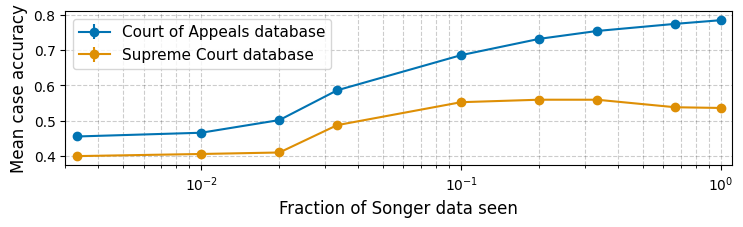

In [6]:
# plot steps against accuracy, one line for each prefix
fig, ax = plt.subplots(figsize=(8.6, 2))

ax.errorbar(x, y_songer, fmt='o-', yerr=y_songer_bar, color=palette[0], label='Court of Appeals database')
ax.errorbar(x, y_sc, fmt='o-', yerr=y_sc_bar, color=palette[1], label='Supreme Court database')

# x log
ax.set_xscale('log')

# x label - Fraction of the training epoch completed
ax.set_xlabel('Fraction of Songer data seen', fontsize=12)
ax.set_ylabel('Mean case accuracy', fontsize=12)

# grid
ax.grid(True, which="both", ls="--", c='black', alpha=0.2)
ax.set_xlim(min(x) * 0.9, 1.1)

# legend in top left
ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
ax.legend(fontsize=11)

# save with tight layout
plt.savefig('plots/generalization.pdf', bbox_inches='tight')

In [9]:
print(f'Max SC: {max(y_sc)*100:.1f}')
print(f'SC Lawma 8B', compute_case_acc(trials['lawma-8b'], 'sc_')[0]*100)
for k, v in y_base.items():
    print(f'SC improvement over {k}, max: {100*(max(y_sc) - v):.1f}, end: {100*(y_sc[-1] - v):.1f}')

# print x corresponding to max of y_sc
print(f'Fraction of Songer data seen at max SC accuracy: {x[np.argmax(y_sc)]}')

Max SC: 56.0
SC Lawma 8B 86.26053143227479
SC improvement over 8b, max: 16.0, end: 13.7
SC improvement over 70b, max: 0.2, end: -2.1
SC improvement over lawma-8b, max: -30.3, end: -32.6
Fraction of Songer data seen at max SC accuracy: 0.2
